In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


2024-01-02 18:45:50.749346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../datasets/Microsoft_Stock.csv',
                 infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


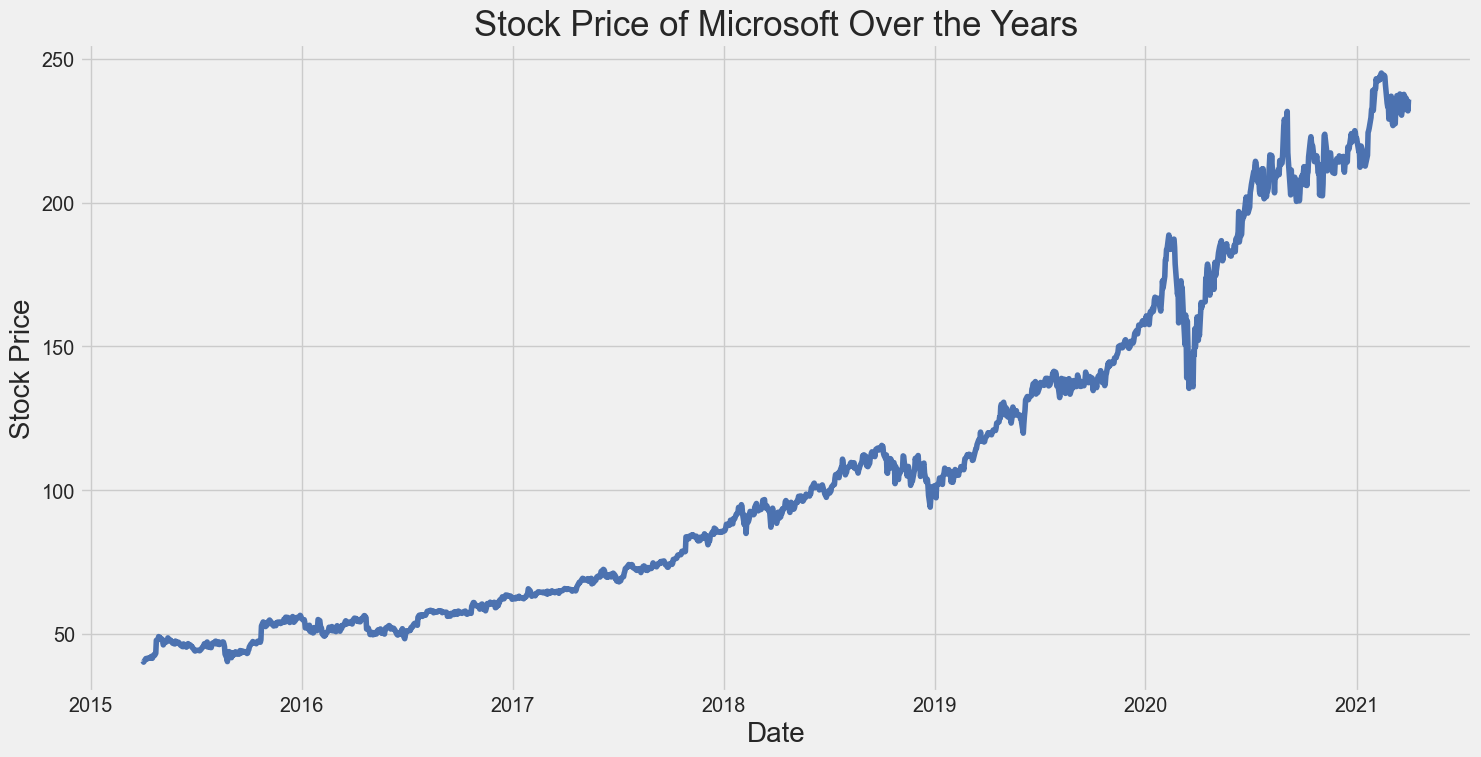

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);

In [5]:
# Normalizes the data
def to_dataset(data):
    data = data.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0,1))
    #return scaler.fit_transform(data)
    return data/255.

# Data train and test
def train_test(data):
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    return train, test

# Time windows - use 10 days to forecast the nest 10 days 
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Model
def creat_model(step_in, step_out, features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(step_in, features)))
    model.add(RepeatVector(step_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Run all functions
def prepare_training(data, step_in, step_out):
    data = to_dataset(data)
    train, test = train_test(data)
    x_train, x_test = windows(train, step_in, step_out)
    y_train, y_test = windows(test, step_in, step_out)
    features = 1
    return x_train, x_test, y_train, y_test, features

In [6]:
step_in, step_out = 10, 10 
epochs = 50 
batch_size = 32

early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)


In [7]:
data = df['Close'].values
data = data.reshape(-1, 1)

In [11]:
x_train, y_train, x_test, y_test, feature = prepare_training(data, step_in, step_out)

In [12]:
model = creat_model(step_in, step_out, feature)

In [13]:
model = creat_model(step_in, step_out, feature)


In [14]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=144, verbose=1,
         validation_data=(x_test, y_test), callbacks=[early,reduce])

Epoch 1/50
8/8 [==============================] - 4s 103ms/step - loss: 0.0842 - mean_squared_error: 0.0842 - val_loss: 0.3307 - val_mean_squared_error: 0.3307 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 0s 57ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.1183 - val_mean_squared_error: 0.1183 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 1s 77ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.1544 - val_mean_squared_error: 0.1544 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 1s 72ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.1239 - val_mean_squared_error: 0.1239 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0770 - val_mean_squared_error: 0.0770 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 0s 62ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0779 - val_mean_sq

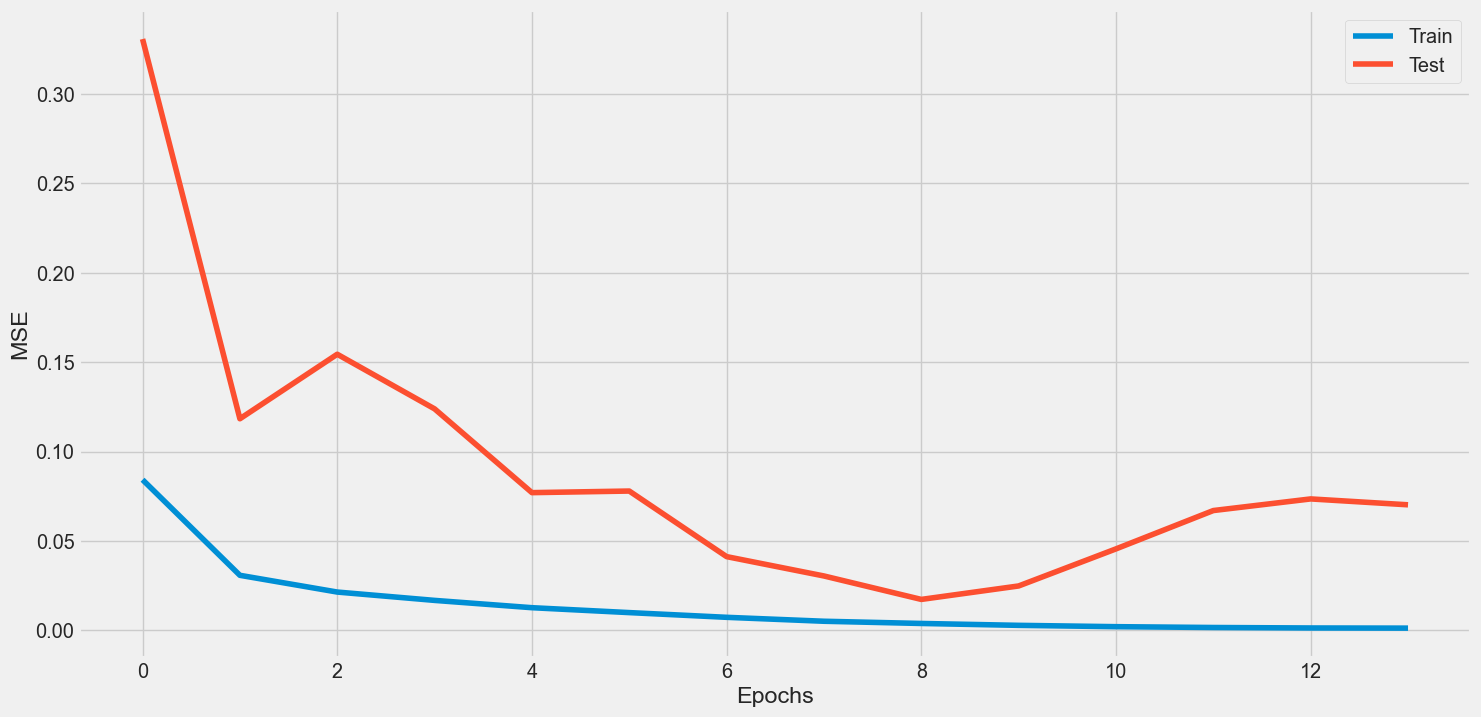

In [15]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);


12/12 [==============================] - 0s 10ms/step


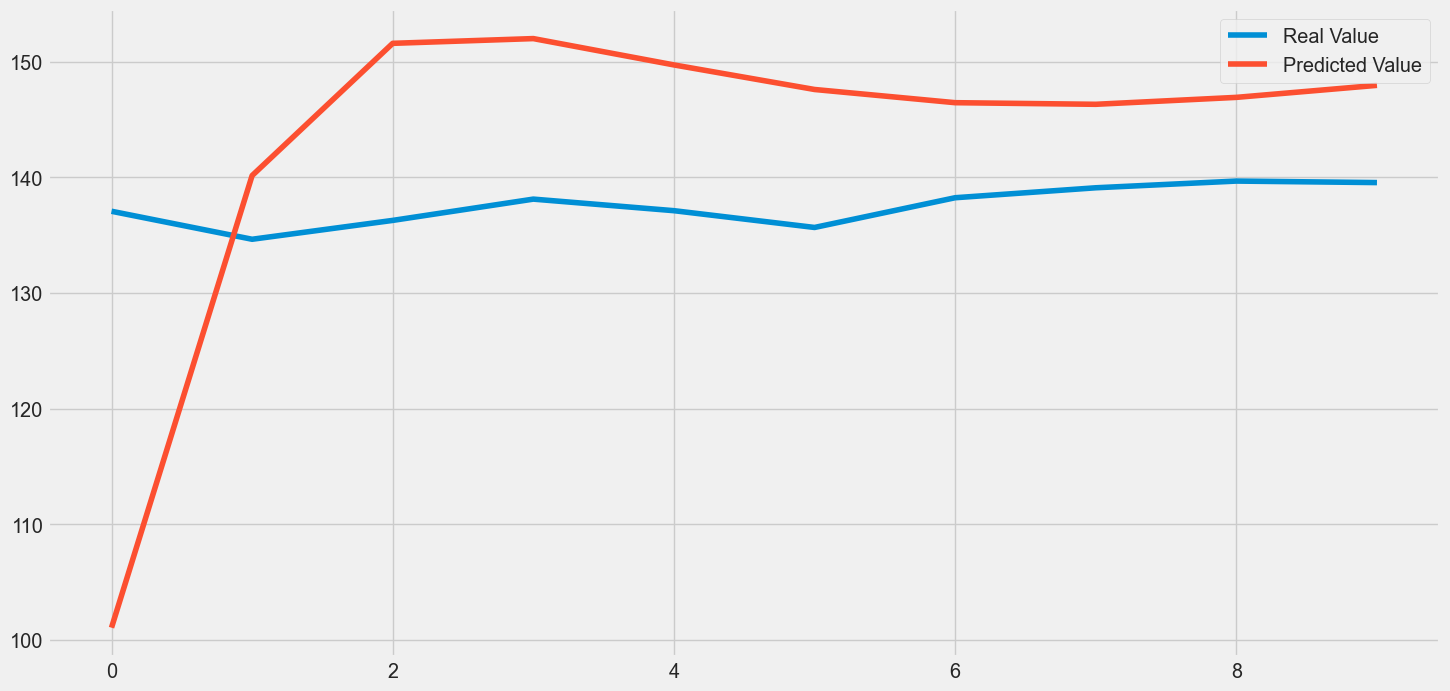

In [16]:
pred = model.predict(x_test)

x = x_test[0]*255.0
y = pred[0]*255.0


plt.plot(x)
plt.plot(y)
plt.legend(['Real Value','Predicted Value']);
